# Handwriting Recognition of Words using TensorFlow

## Dataset

This project involves using the part of [IAM Handwriting Datsbase](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database) which includes words. This famous database contains the following information:

- 657 writers have contributed their handwriting samples
- 1,539 pages of scanned text
- 5,685 isolated and labeled sentences
- 13,353 isolated and labeled text lines
- 115,320 isolated and labeled words

The dataset consists of the folders with words images and a text file with keys for the each image. Text file has the next structure: 
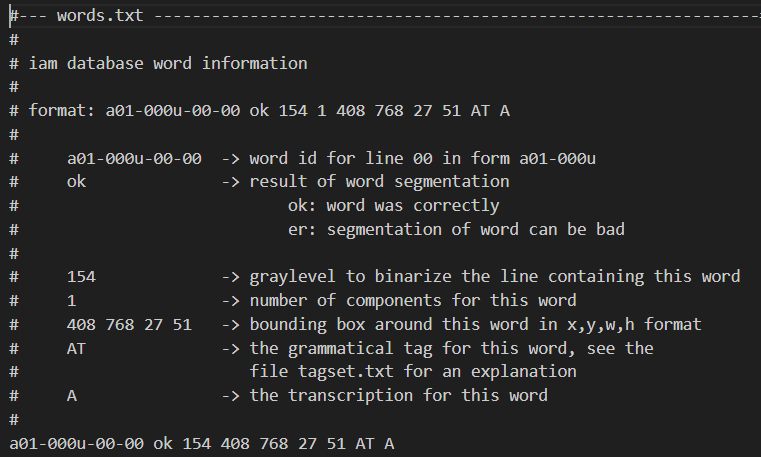


## Model

The model is designed to recognize handwritten text in images. It's a type of CNN (convolutional neural network) designed explicitly for sequence labeling tasks like this. The model takes images as input and produces a sequence of labels (character labels) for each image as output.

## Result

### Imports

In [39]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.metrics import CWERMetric
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.model_utils import residual_block

from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import os
import stow
from tqdm import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [40]:
dataset_path = stow.join('Datasets', 'IAM_Words')
model_path = os.path.join('Models', datetime.now().strftime("%Y%m%d%H%M"))

### Preprocessing dataset 

This code pre-processes a dataset by reading and parsing a file named words.txt. It extracts the folder names and file names to construct file **paths and labels**. If the file path exists, it adds the file path and label to the **dataset** list. It also updates the **vocab** set with the list of characters in the label. Additionally, it updates **max_len** to be the maximum of its current value and the length of the label. The code skips lines starting with "#" and lines containing "err" in the second element.

In [41]:
dataset, vocab_set, max_len = [], set(), 0

words = open(stow.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = line_split[0][:8]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    rel_path = stow.join(dataset_path, "words", folder1, folder2, file_name)
    if not stow.exists(rel_path):
        continue

    dataset.append([rel_path, label])
    vocab_set.update(list(label))
    max_len = max(max_len, len(label))

    vocab = "".join(vocab_set)

  1%|          | 1264/115338 [00:00<00:29, 3896.84it/s]

  5%|▌         | 5833/115338 [00:01<00:25, 4304.95it/s]


KeyboardInterrupt: 

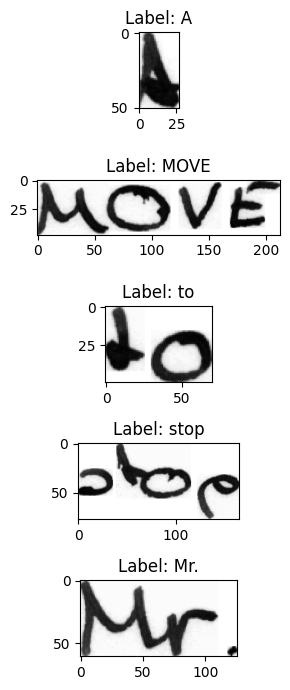

In [ ]:
first_five_images = dataset[:5]

fig, axes = plt.subplots(5, 1, figsize=(3, 7))
for i, (image_path, label) in enumerate(first_five_images):
    image = mpimg.imread(image_path)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title('Label: '+ label)

plt.tight_layout()
plt.show()

### Defining data generator

This DataProvider object applies the following transformations to the dataset:

- **ImageReader**: reads the image files using OpenCV and returns their pixel values as numpy arrays;
- **ImageResizer**: resizes the images to a specified width and height while maintaining or discarding the aspect ratio. You may choose this depending on your dataset and training results;
- **LabelIndexer**: maps each character in the labels to a unique integer index using the vocabulary set;
- **LabelPadding**: pads the labels with the padding value (set to the index of the last character in the vocabulary) to make all the labels have the same length as the maximum text length.

It splits the transformed dataset into 90% training set and 10% validation set. During training, it uses **RandomBrightness**, **RandomRotate**, **RandomSharpen** and **RandomErodeDilate** transformations to create diverse and realistic training examples. These transformations apply brightness, rotation, and erosion/dilation to the images in the training set.

In [ ]:
height = 32
width = 128
batch_size = 16

In [ ]:
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(width, height, keep_aspect_ratio=False),
        LabelIndexer(vocab),
        LabelPadding(max_word_length=max_len, padding_value=len(vocab)),
        ],
)

train_data_provider, val_data_provider = data_provider.split(split = 0.9)

train_data_provider.augmentors = [
    RandomBrightness(), 
    RandomErodeDilate(),
    RandomSharpen(),
    RandomRotate(angle=10), 
    ]

### Creating the model

In [ ]:
activation="leaky_relu"
dropout=0.2
input_dim=(height, width, 3)
output_dim=len(vocab)
learning_rate = 0.0005

#### The models structure

The model is made up of several convolutional and max-pooling layers that extract features from the images and a couple of bidirectional LSTM (long short-term memory) layers that capture the relationships between the characters in the labels. The output from the LSTM layers is passed through a dense layer with a softmax activation, which produces a probability distribution over the characters in the vocabulary for each time step. This helps the model predict the correct label for each character in the input image.


In [ ]:
inputs = layers.Input(shape=input_dim, name="input")

input = layers.Lambda(lambda x: x / 255)(inputs)

x1 = residual_block(input, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

x4 = residual_block(x3, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
x5 = residual_block(x4, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

x6 = residual_block(x5, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
x7 = residual_block(x6, 64, activation=activation, skip_conv=True, strides=1, dropout=dropout)

x8 = residual_block(x7, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)
x9 = residual_block(x8, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

blstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)
blstm = layers.Dropout(dropout)(blstm)

output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

model = Model(inputs=inputs, outputs=output)

#### The models compiling
The model is trained using CTC loss and the Adam optimizer. CTC loss allows the model to output character labels without enforcing an alignment between input and output sequences. The Adam optimizer adjusts learning rates based on historical gradient information.

The CWER metric, defined in the CWERMetric class, evaluates the model's performance. It measures the ratio of incorrect characters in the model's predictions to the total number of characters in the ground truth labels. The CWER metric evaluates the model's accuracy at the character level and is commonly used for handwriting text recognition models.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=CTCloss(),
              metrics=[CWERMetric(padding_token=len(vocab))],
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 32, 128, 3)]         0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32, 128, 3)           0         ['input[0][0]']               
                                                                                                  
 conv2d (Conv2D)             (None, 32, 128, 16)          448       ['lambda[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 32, 128, 16)          64        ['conv2d[0][0]']              
 Normalization)                                                                               

#### Define the callbacks

The **EarlyStopping** feature stops training if the model fails to improve on the validation set after a certain number of epochs. The **ModelCheckpoint** saves the model weights when the validation performance improves. The **ReduceLROnPlateau** decreases the learning rate if the validation performance doesn't improve. The **TensorBoard** logs training and validation metrics for visualization. The **Model2onnx** converts the trained model to the ONNX format for easy use in other environments.

In [ ]:
# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1)
checkpoint = ModelCheckpoint(f"{model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(model_path)
tb_callback = TensorBoard(f"{model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=10, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{model_path}/model.h5")

### Train the model

In [ ]:
train_epochs = 1000
train_workers = 20

In [ ]:
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=train_workers
)

Epoch 1/1000

1221/1221 [==============================] - ETA: 0s - loss: 15.5951 - CER: 1.2920 - WER: 1.0000
Epoch 1: val_CER improved from inf to 1.00000, saving model to Models\202402031801\model.h5


C:\Users\katana_iryna\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1221/1221 [==============================] - 159s 116ms/step - loss: 15.5951 - CER: 1.2918 - WER: 1.0000 - val_loss: 13.7980 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04
Epoch 2/1000
1221/1221 [==============================] - ETA: 0s - loss: 12.8498 - CER: 0.9294 - WER: 0.9653
Epoch 2: val_CER improved from 1.00000 to 0.72603, saving model to Models\202402031801\model.h5
1221/1221 [==============================] - 135s 110ms/step - loss: 12.8498 - CER: 0.9293 - WER: 0.9653 - val_loss: 12.3296 - val_CER: 0.7260 - val_WER: 0.8904 - lr: 5.0000e-04
Epoch 3/1000
1221/1221 [==============================] - ETA: 0s - loss: 11.5286 - CER: 0.7318 - WER: 0.8775
Epoch 3: val_CER improved from 0.72603 to 0.61154, saving model to Models\202402031801\model.h5
1221/1221 [==============================] - 136s 112ms/step - loss: 11.5286 - CER: 0.7318 - WER: 0.8775 - val_loss: 10.2984 - val_CER: 0.6115 - val_WER: 0.7835 - lr: 5.0000e-04
Epoch 4/1000
1221/1221 [==============================

KeyboardInterrupt: 

In [ ]:
# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(model_path, "val.csv"))

### Training history

Now we can analyze how the model was trained. Let's type in terminal **tensorboard --logdir Models\202401171801\logs**.
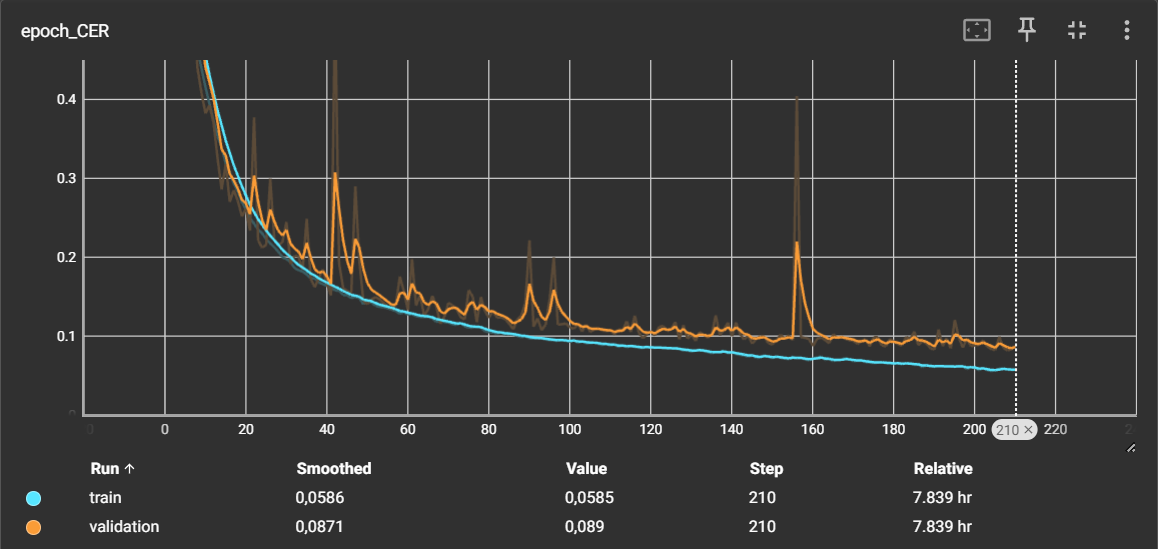
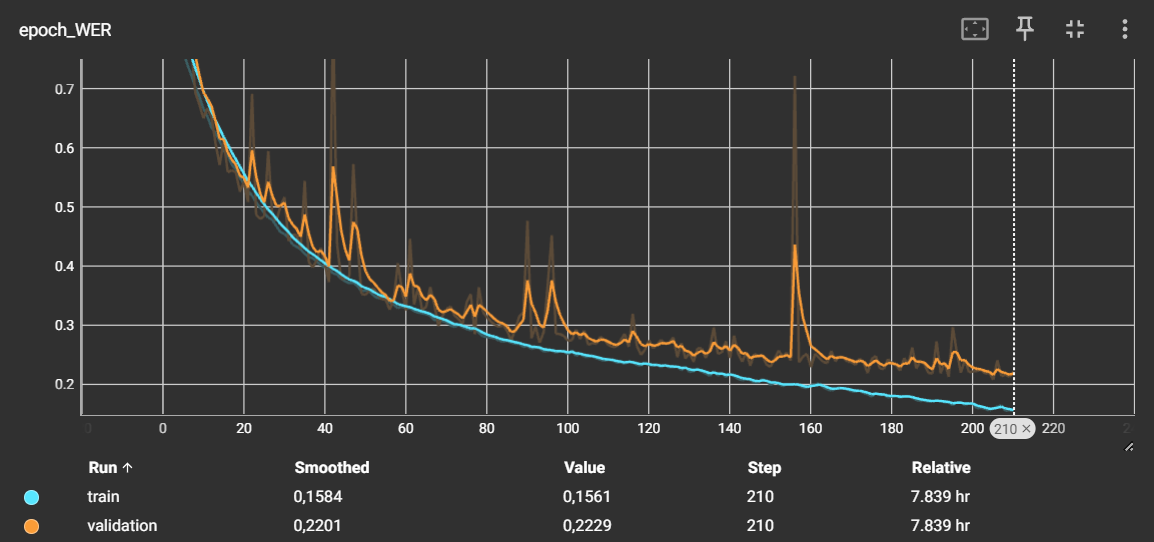

### Testing the model

In [52]:
import cv2
import typing
import numpy as np

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, self.input_shape[:2][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(None, {self.input_name: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load("Models/202401171801/configs.yaml")

    model = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab)

    df = pd.read_csv("Models/202401171801/val.csv").values.tolist()

    accum_cer = []
    for image_path, label in tqdm(df):
        if image_path=="Datasets\IAM_Words\words\g06\g06-037n\g06-037n-08-02.png":
            continue
        image = cv2.imread(image_path)

        prediction_text = model.predict(image)

        if prediction_text is not None:
            cer = get_cer(prediction_text, label)
            print(f"Image: {image_path}, Label: {label}, Prediction: {prediction_text}, CER: {cer}")
            accum_cer.append(cer)
        else:
            print(f"Image: {image_path}, Label: {label}, Prediction: None (No prediction available)")

    # resize by 4x
    # image = cv2.resize(image, (image.shape[1] * 4, image.shape[0] * 4))
    # cv2.imshow("Image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

print(f"Average CER: {np.average(accum_cer)}")

  1%|          | 15/2171 [00:00<00:15, 138.37it/s]

Image: Datasets\IAM_Words\words\a01\a01-038x\a01-038x-08-05.png, Label: Government, Prediction: Government, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-038x\a01-038x-00-05.png, Label: Rhodesian, Prediction: Rhodesion, CER: 0.1111111111111111
Image: Datasets\IAM_Words\words\g06\g06-050d\g06-050d-03-07.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\k07\k07-059a\k07-059a-07-03.png, Label: where, Prediction: where, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094d\c03-094d-01-01.png, Label: pushing, Prediction: pushing, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-101b\f07-101b-02-04.png, Label: made, Prediction: made, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037d\g06-037d-02-04.png, Label: express, Prediction: express, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-063u\a01-063u-04-07.png, Label: Washington, Prediction: Washington, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011o\g06-011o-05-04.png, Label: What, Prediction: What, C

  2%|▏         | 45/2171 [00:00<00:14, 146.22it/s]

Image: Datasets\IAM_Words\words\g06\g06-050g\g06-050g-02-02.png, Label: distinguished, Prediction: distinguished, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045m\g06-045m-07-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050l\g06-050l-07-09.png, Label: cured, Prediction: cured, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096e\c03-096e-03-06.png, Label: ineffectuality, Prediction: ineffectuality, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081e\c03-081e-04-06.png, Label: seen, Prediction: seen, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081f\c03-081f-02-03.png, Label: we, Prediction: we, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003b\c03-003b-04-06.png, Label: so, Prediction: so, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026l\g06-026l-03-11.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-020x\a01-020x-04-01.png, Label: do, Prediction: do, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f

  3%|▎         | 75/2171 [00:00<00:14, 140.19it/s]

Image: Datasets\IAM_Words\words\a01\a01-117u\a01-117u-05-06.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003d\c03-003d-04-03.png, Label: background, Prediction: background, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-026u\a01-026u-05-00.png, Label: boycotted, Prediction: boycotted, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-122u\a01-122u-02-03.png, Label: this, Prediction: this, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045l\g06-045l-02-05.png, Label: trial, Prediction: trial, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037d\g06-037d-03-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-082u\a01-082u-09-01.png, Label: personality, Prediction: personality, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-022b\g07-022b-05-05.png, Label: unfortunate, Prediction: inforturate, CER: 0.18181818181818182
Image: Datasets\IAM_Words\words\k07\k07-059a\k07-059a-06-09.png, Label: 'd, Prediction: ad, CER: 0.5

  5%|▍         | 106/2171 [00:00<00:13, 147.50it/s]

Image: Datasets\IAM_Words\words\a01\a01-117u\a01-117u-10-08.png, Label: per, Prediction: per, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000c\c03-000c-06-05.png, Label: are, Prediction: are, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047p\g06-047p-02-03.png, Label: than, Prediction: than, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003c\c03-003c-04-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-026u\a01-026u-03-01.png, Label: Rhodesia's, Prediction: Rhodesia's, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-030x\a01-030x-00-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018b\g06-018b-07-02.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081c\c03-081c-05-01.png, Label: makes, Prediction: makes, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-007b\g07-007b-05-08.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018e\g06-018e-06-00

  6%|▋         | 140/2171 [00:00<00:12, 156.29it/s]

Image: Datasets\IAM_Words\words\f07\f07-084b\f07-084b-02-05.png, Label: week, Prediction: week, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-053u\a01-053u-02-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-074a\g07-074a-06-01.png, Label: find, Prediction: find, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026e\g06-026e-02-07.png, Label: English, Prediction: English, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003e\c03-003e-00-05.png, Label: play, Prediction: play, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084b\c03-084b-07-03.png, Label: ambition, Prediction: ambition, CER: 0.0
Image: Datasets\IAM_Words\words\n02\n02-082a\n02-082a-01-03.png, Label: gaze, Prediction: gaze, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-051b\h07-051b-06-00.png, Label: including, Prediction: including, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094e\c03-094e-03-06.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g

  8%|▊         | 178/2171 [00:01<00:11, 170.97it/s]

Image: Datasets\IAM_Words\words\g06\g06-045m\g06-045m-05-00.png, Label: France, Prediction: France, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-026a\g07-026a-02-07.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-030u\a01-030u-10-00.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047b\g06-047b-04-03.png, Label: unorthodox, Prediction: unorthodox, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037o\g06-037o-00-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-084b\f07-084b-05-07.png, Label: soup, Prediction: sop, CER: 0.25
Image: Datasets\IAM_Words\words\g06\g06-042f\g06-042f-02-13.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-026a\g07-026a-01-03.png, Label: betrayed, Prediction: betrayed, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-028a\f07-028a-02-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016e\c03-016e-0

 10%|▉         | 217/2171 [00:01<00:11, 174.36it/s]

Image: Datasets\IAM_Words\words\g06\g06-050h\g06-050h-03-01.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042i\g06-042i-02-10.png, Label: on, Prediction: on, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094b\c03-094b-06-01.png, Label: modulate, Prediction: modulate, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042b\g06-042b-01-07.png, Label: cure, Prediction: cure, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-003b\g07-003b-08-03.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045p\g06-045p-04-02.png, Label: being, Prediction: being, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096f\c03-096f-04-03.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011j\g06-011j-10-00.png, Label: particularly, Prediction: particularly, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-040b\h07-040b-00-00.png, Label: All, Prediction: All, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-054a\h07-

 11%|█         | 236/2171 [00:01<00:11, 170.72it/s]

Image: Datasets\IAM_Words\words\c03\c03-016a\c03-016a-08-04.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084e\c03-084e-05-00.png, Label: Fall, Prediction: Fall, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011m\g06-011m-06-03.png, Label: At, Prediction: At, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081a\c03-081a-01-00.png, Label: technical, Prediction: technical, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011j\g06-011j-02-07.png, Label: him, Prediction: him, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-076a\f07-076a-00-00.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037p\g06-037p-00-10.png, Label: false, Prediction: false, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000c\c03-000c-03-07.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026i\g06-026i-04-06.png, Label: temporary, Prediction: temporary, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047f\g06-04

 13%|█▎        | 273/2171 [00:01<00:11, 159.42it/s]

Image: Datasets\IAM_Words\words\a01\a01-030u\a01-030u-03-07.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-081a\f07-081a-08-05.png, Label: other, Prediction: other, CER: 0.0
Image: Datasets\IAM_Words\words\k07\k07-059a\k07-059a-01-07.png, Label: existed, Prediction: existed, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-018a\g07-018a-00-01.png, Label: may, Prediction: may, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011p\g06-011p-05-03.png, Label: what, Prediction: what, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011l\g06-011l-05-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047b\g06-047b-02-00.png, Label: later, Prediction: later, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018o\g06-018o-08-04.png, Label: I, Prediction: I, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018n\g06-018n-10-05.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047i\g06-047i-04-05.png, 

 14%|█▍        | 314/2171 [00:01<00:10, 172.23it/s]

Image: Datasets\IAM_Words\words\f07\f07-024a\f07-024a-07-00.png, Label: fragment, Prediction: fragment, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021e\c03-021e-01-07.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-007b\c03-007b-02-09.png, Label: wet, Prediction: wet, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018i\g06-018i-01-06.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016a\c03-016a-08-07.png, Label: leaves, Prediction: leaves, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045p\g06-045p-05-02.png, Label: its, Prediction: its, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-066a\h07-066a-05-06.png, Label: still, Prediction: still, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042c\g06-042c-02-05.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037g\g06-037g-01-14.png, Label: understand, Prediction: understand, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050

 16%|█▋        | 353/2171 [00:02<00:09, 182.28it/s]

Image: Datasets\IAM_Words\words\c03\c03-021f\c03-021f-04-03.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045g\g06-045g-05-05.png, Label: aged, Prediction: aged, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011p\g06-011p-06-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047e\g06-047e-02-10.png, Label: increasing, Prediction: increasing, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026k\g06-026k-01-03.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031h\g06-031h-00-00.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\a01\a01-053u\a01-053u-09-06.png, Label: Senate, Prediction: Senate, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037j\g06-037j-00-03.png, Label: however, Prediction: however, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-033a\h07-033a-09-00.png, Label: dependence, Prediction: dependence, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g

 18%|█▊        | 391/2171 [00:02<00:09, 183.81it/s]

Image: Datasets\IAM_Words\words\c03\c03-096e\c03-096e-06-05.png, Label: act, Prediction: act, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-022a\g07-022a-04-05.png, Label: unavoidable, Prediction: unavoidable, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042e\g06-042e-03-04.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018o\g06-018o-06-02.png, Label: against, Prediction: against, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-003b\g07-003b-07-02.png, Label: Gamba, Prediction: Gamba, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031p\g06-031p-06-08.png, Label: God, Prediction: God, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-057a\h07-057a-07-04.png, Label: new, Prediction: new, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-092b\f07-092b-05-06.png, Label: having, Prediction: laing, CER: 0.3333333333333333
Image: Datasets\IAM_Words\words\g06\g06-047m\g06-047m-02-01.png, Label: or, Prediction: or, CER: 0.0
Image: Datasets\IAM_Words\w

 20%|█▉        | 429/2171 [00:02<00:09, 183.22it/s]

Image: Datasets\IAM_Words\words\g06\g06-018h\g06-018h-06-06.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011h\g06-011h-04-05.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011i\g06-011i-05-05.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-007b\c03-007b-04-04.png, Label: -, Prediction: -, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-071a\h07-071a-07-04.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000d\c03-000d-02-00.png, Label: Square, Prediction: Sqguare, CER: 0.16666666666666666
Image: Datasets\IAM_Words\words\c03\c03-007c\c03-007c-01-02.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-082u\a01-082u-04-02.png, Label: America, Prediction: America, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-019a\f07-019a-01-04.png, Label: those, Prediction: those, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018k\g06-018k-

 22%|██▏       | 468/2171 [00:02<00:09, 181.54it/s]

Image: Datasets\IAM_Words\words\h07\h07-071a\h07-071a-02-08.png, Label: therefore, Prediction: therefoe, CER: 0.1111111111111111
Image: Datasets\IAM_Words\words\g06\g06-047l\g06-047l-01-08.png, Label: later, Prediction: later, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-058u\a01-058u-04-09.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021e\c03-021e-01-08.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-042b\f07-042b-05-04.png, Label: ,, Prediction: ., CER: 1.0
Image: Datasets\IAM_Words\words\g06\g06-045d\g06-045d-02-08.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-028a\g07-028a-03-05.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031k\g06-031k-02-01.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047j\g06-047j-00-04.png, Label: medicine, Prediction: medicine, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-132x\

 23%|██▎       | 506/2171 [00:02<00:09, 181.24it/s]

Image: Datasets\IAM_Words\words\g06\g06-050e\g06-050e-06-03.png, Label: appears, Prediction: appears, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-084a\f07-084a-00-00.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets\IAM_Words\words\k07\k07-059a\k07-059a-03-09.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021d\c03-021d-09-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-102u\a01-102u-03-10.png, Label: :, Prediction: :, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094d\c03-094d-10-04.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-054a\h07-054a-00-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-091u\a01-091u-04-01.png, Label: Service, Prediction: Service, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-051b\h07-051b-01-07.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-030x\a01-030x-01-01.png, Label: ., Predic

 25%|██▌       | 544/2171 [00:03<00:08, 182.58it/s]

Image: Datasets\IAM_Words\words\g06\g06-037c\g06-037c-08-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047l\g06-047l-04-04.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011g\g06-011g-04-13.png, Label: lively, Prediction: lively, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-030x\a01-030x-02-07.png, Label: :, Prediction: :, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018e\g06-018e-04-01.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031g\g06-031g-06-08.png, Label: may, Prediction: may, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000d\c03-000d-01-01.png, Label: A, Prediction: a, CER: 1.0
Image: Datasets\IAM_Words\words\g06\g06-018m\g06-018m-00-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-014x\a01-014x-00-05.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-101a\f07-101a-07-01.png, Label: A, Prediction

 27%|██▋       | 583/2171 [00:03<00:08, 181.33it/s]

Image: Datasets\IAM_Words\words\c03\c03-096b\c03-096b-05-09.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047p\g06-047p-04-08.png, Label: the, Prediction: thee, CER: 0.3333333333333333
Image: Datasets\IAM_Words\words\f07\f07-021b\f07-021b-01-01.png, Label: boiling, Prediction: boiling, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-007d\c03-007d-02-02.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011l\g06-011l-06-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-060a\h07-060a-01-03.png, Label: addition, Prediction: addition, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-042b\f07-042b-03-07.png, Label: ward, Prediction: ward, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-091u\a01-091u-05-02.png, Label: least, Prediction: least, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047c\g06-047c-05-07.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g

 29%|██▊       | 623/2171 [00:03<00:08, 180.12it/s]

Image: Datasets\IAM_Words\words\a01\a01-063u\a01-063u-01-04.png, Label: past, Prediction: past, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096f\c03-096f-05-09.png, Label: us, Prediction: us, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084e\c03-084e-05-07.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084c\c03-084c-05-03.png, Label: on, Prediction: on, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-000b\g07-000b-07-10.png, Label: whole, Prediction: whole, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011i\g06-011i-00-05.png, Label: month, Prediction: month, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047c\g06-047c-04-05.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050b\g06-050b-06-00.png, Label: even-tempered, Prediction: even-tempered, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-117u\a01-117u-07-06.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\k07\k07-067a\k07-06

 30%|███       | 660/2171 [00:03<00:08, 175.91it/s]

Image: Datasets\IAM_Words\words\g06\g06-042o\g06-042o-00-03.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042p\g06-042p-01-00.png, Label: 1960s, Prediction: 1960s, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037r\g06-037r-07-07.png, Label: first, Prediction: first, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050h\g06-050h-02-04.png, Label: distinguished, Prediction: distinguished, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-003a\g07-003a-07-02.png, Label: TO, Prediction: TO, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047o\g06-047o-08-00.png, Label: consulted, Prediction: consulted, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037h\g06-037h-00-07.png, Label: may, Prediction: may, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026c\g06-026c-00-08.png, Label: happens, Prediction: happens, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081a\c03-081a-06-07.png, Label: Dinsdale, Prediction: Dinsdate, CER: 0.125
Image: Datasets\I

 32%|███▏      | 697/2171 [00:04<00:08, 179.06it/s]

Image: Datasets\IAM_Words\words\g06\g06-047g\g06-047g-04-00.png, Label: men, Prediction: men, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011m\g06-011m-00-07.png, Label: still, Prediction: still, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037h\g06-037h-05-05.png, Label: Anglesey's, Prediction: Anglesey's, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042m\g06-042m-00-07.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-007u\a01-007u-05-03.png, Label: THE, Prediction: THE, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-087a\c03-087a-00-05.png, Label: some, Prediction: some, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-088b\f07-088b-05-07.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-038x\a01-038x-01-03.png, Label: attend, Prediction: attend, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081b\c03-081b-07-02.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031e\g06-031e

 33%|███▎      | 717/2171 [00:04<00:07, 182.84it/s]

Image: Datasets\IAM_Words\words\g06\g06-011g\g06-011g-03-05.png, Label: great, Prediction: grreat, CER: 0.2
Image: Datasets\IAM_Words\words\c03\c03-094a\c03-094a-01-08.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042b\g06-042b-01-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-028b\g07-028b-04-02.png, Label: ever, Prediction: ever, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011b\g06-011b-03-04.png, Label: anything, Prediction: anything, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047m\g06-047m-05-04.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047l\g06-047l-02-06.png, Label: earth, Prediction: earth, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-019a\f07-019a-01-05.png, Label: mammoth, Prediction: mammoth, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011b\g06-011b-00-07.png, Label: still, Prediction: still, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021a\c03

 36%|███▌      | 774/2171 [00:04<00:08, 164.71it/s]

Image: Datasets\IAM_Words\words\g06\g06-031o\g06-031o-10-03.png, Label: may, Prediction: may, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016b\c03-016b-01-08.png, Label: lives, Prediction: lives, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026j\g06-026j-00-09.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-007a\g07-007a-03-02.png, Label: AND, Prediction: AND, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011i\g06-011i-03-03.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-007a\g07-007a-00-02.png, Label: POPULAR, Prediction: POPULAR, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-088b\f07-088b-00-07.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-003a\g07-003a-02-04.png, Label: BYRON'S, Prediction: BYRON'S, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-077u\a01-077u-01-07.png, Label: tough, Prediction: tough, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018o\g06-

 37%|███▋      | 811/2171 [00:04<00:07, 174.19it/s]

Image: Datasets\IAM_Words\words\f07\f07-021b\f07-021b-02-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037o\g06-037o-05-02.png, Label: new, Prediction: new, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016a\c03-016a-00-03.png, Label: heart, Prediction: heart, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-046a\f07-046a-00-05.png, Label: Australia, Prediction: Australia, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037n\g06-037n-02-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-025a\h07-025a-05-06.png, Label: shops, Prediction: shops, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018a\g06-018a-01-07.png, Label: Rome, Prediction: Rome, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094d\c03-094d-02-00.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045i\g06-045i-02-02.png, Label: give, Prediction: give, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003b\c03-003b-07-

 39%|███▉      | 847/2171 [00:04<00:07, 175.44it/s]

Image: Datasets\IAM_Words\words\c03\c03-096f\c03-096f-00-05.png, Label: therefore, Prediction: themefore, CER: 0.1111111111111111
Image: Datasets\IAM_Words\words\g06\g06-042i\g06-042i-01-05.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011f\g06-011f-06-00.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031g\g06-031g-00-04.png, Label: event, Prediction: event, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018m\g06-018m-03-10.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\c03\c03-003a\c03-003a-01-06.png, Label: cinema, Prediction: cinema, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-084b\f07-084b-05-05.png, Label: sort, Prediction: sort, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-075a\h07-075a-01-03.png, Label: movement, Prediction: movement, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050b\g06-050b-06-05.png, Label: easily, Prediction: easily, CER: 0.0
Image: Datasets\IAM_Wo

 40%|███▉      | 865/2171 [00:05<00:07, 171.81it/s]

Image: Datasets\IAM_Words\words\a01\a01-014x\a01-014x-01-03.png, Label: on, Prediction: on, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-084a\f07-084a-00-06.png, Label: much, Prediction: much, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-033a\h07-033a-04-02.png, Label: shopkeeper, Prediction: shopkeeper, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016c\c03-016c-04-02.png, Label: learns, Prediction: learns, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045o\g06-045o-01-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-003a\g07-003a-02-01.png, Label: AND, Prediction: AND, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000d\c03-000d-02-07.png, Label: pro-, Prediction: pro-, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-071a\h07-071a-02-03.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-007b\g07-007b-02-03.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045g\g06-045g-04-07

 42%|████▏     | 902/2171 [00:05<00:07, 172.44it/s]

Image: Datasets\IAM_Words\words\g06\g06-026o\g06-026o-03-07.png, Label: English, Prediction: English, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-053x\a01-053x-08-02.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011g\g06-011g-07-02.png, Label: in, Prediction: is, CER: 0.5
Image: Datasets\IAM_Words\words\a01\a01-049u\a01-049u-03-01.png, Label: gossip, Prediction: gossip, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018o\g06-018o-04-08.png, Label: place, Prediction: place, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-117u\a01-117u-06-06.png, Label: demanded, Prediction: demanded, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045b\g06-045b-05-00.png, Label: success, Prediction: success, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-026x\a01-026x-09-05.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094c\c03-094c-01-09.png, Label: palely, Prediction: palely, CER: 0.0
Image: Datasets\IAM_Words\words\f

 43%|████▎     | 940/2171 [00:05<00:06, 177.53it/s]

Image: Datasets\IAM_Words\words\c03\c03-087a\c03-087a-00-07.png, Label: beyond, Prediction: beyond, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-066a\h07-066a-03-03.png, Label: town, Prediction: town, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-081b\f07-081b-00-02.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026i\g06-026i-00-03.png, Label: truly, Prediction: truly, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050a\g06-050a-02-01.png, Label: doing, Prediction: doing, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026l\g06-026l-04-05.png, Label: assumption, Prediction: assaumption, CER: 0.1
Image: Datasets\IAM_Words\words\g06\g06-026p\g06-026p-01-03.png, Label: perhaps, Prediction: perhaps, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-000b\g07-000b-02-06.png, Label: heard, Prediction: heard, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-057a\h07-057a-07-00.png, Label: opportunities, Prediction: sppartuntios, CER: 0.30769230769

 45%|████▌     | 979/2171 [00:05<00:06, 182.69it/s]

Image: Datasets\IAM_Words\words\g06\g06-018b\g06-018b-06-06.png, Label: against, Prediction: against, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011e\g06-011e-04-14.png, Label: gay, Prediction: gay, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050b\g06-050b-03-05.png, Label: He, Prediction: He, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000c\c03-000c-01-05.png, Label: at, Prediction: At, CER: 0.5
Image: Datasets\IAM_Words\words\c03\c03-096e\c03-096e-01-01.png, Label: from, Prediction: from, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026h\g06-026h-02-08.png, Label: one, Prediction: one, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-042a\f07-042a-04-06.png, Label: served, Prediction: served, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031m\g06-031m-08-04.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096c\c03-096c-01-05.png, Label: rest, Prediction: rest, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011o\g06-011o-00-06.png

 47%|████▋     | 1018/2171 [00:05<00:06, 183.88it/s]

Image: Datasets\IAM_Words\words\c03\c03-087f\c03-087f-06-05.png, Label: if, Prediction: if, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047k\g06-047k-03-01.png, Label: human, Prediction: human, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050r\g06-050r-03-07.png, Label: found, Prediction: found, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-044a\h07-044a-00-05.png, Label: expendi-, Prediction: expendi-, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-020u\a01-020u-01-02.png, Label: House, Prediction: House, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084d\c03-084d-01-05.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016a\c03-016a-05-02.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042k\g06-042k-01-08.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-007a\g07-007a-06-03.png, Label: EVERYTHING, Prediction: EVERYTHING, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-1

 49%|████▊     | 1056/2171 [00:06<00:06, 182.71it/s]

Image: Datasets\IAM_Words\words\g06\g06-045o\g06-045o-08-03.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-043x\a01-043x-04-07.png, Label: negro, Prediction: negro, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045o\g06-045o-00-07.png, Label: wife's, Prediction: wife's, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026k\g06-026k-05-01.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021f\c03-021f-06-08.png, Label: need, Prediction: need, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031o\g06-031o-04-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050a\g06-050a-00-00.png, Label: Mauro's, Prediction: Mauro's, CER: 0.0
Image: Datasets\IAM_Words\words\k07\k07-059a\k07-059a-00-05.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-030a\h07-030a-03-02.png, Label: development, Prediction: development, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-018

 50%|█████     | 1094/2171 [00:06<00:05, 179.97it/s]

Image: Datasets\IAM_Words\words\c03\c03-016a\c03-016a-04-04.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018d\g06-018d-03-01.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\a01\a01-053u\a01-053u-01-02.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-096u\a01-096u-00-06.png, Label: public, Prediction: publc, CER: 0.16666666666666666
Image: Datasets\IAM_Words\words\g06\g06-037r\g06-037r-03-07.png, Label: opened, Prediction: opened, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094b\c03-094b-01-05.png, Label: Allen, Prediction: Allen, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018i\g06-018i-00-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094a\c03-094a-02-04.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-063b\h07-063b-03-05.png, Label: about, Prediction: about, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-04

 52%|█████▏    | 1132/2171 [00:06<00:05, 180.59it/s]

Image: Datasets\IAM_Words\words\h07\h07-066b\h07-066b-01-00.png, Label: National, Prediction: National, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-078a\h07-078a-07-00.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042d\g06-042d-01-10.png, Label: douloureux, Prediction: douloureux, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050e\g06-050e-06-06.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037e\g06-037e-07-02.png, Label: since, Prediction: since, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-051b\h07-051b-05-00.png, Label: administrative, Prediction: admistrative, CER: 0.14285714285714285
Image: Datasets\IAM_Words\words\g06\g06-045r\g06-045r-04-04.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045m\g06-045m-05-04.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045b\g06-045b-04-04.png, Label: extraordinary, Prediction: extraordinary

 54%|█████▍    | 1171/2171 [00:06<00:05, 180.77it/s]

Image: Datasets\IAM_Words\words\g06\g06-042c\g06-042c-03-00.png, Label: Anglesey, Prediction: Anglesey, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011j\g06-011j-07-07.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-069a\g07-069a-05-01.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-051b\h07-051b-01-04.png, Label: demand, Prediction: demand, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037m\g06-037m-04-06.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-071a\h07-071a-07-05.png, Label: Schemes, Prediction: Schemes, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050o\g06-050o-05-05.png, Label: man, Prediction: man, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-020u\a01-020u-01-03.png, Label: despite, Prediction: despite, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042j\g06-042j-04-01.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-071a\h07-07

 55%|█████▍    | 1190/2171 [00:06<00:05, 181.86it/s]

Image: Datasets\IAM_Words\words\g06\g06-026e\g06-026e-03-02.png, Label: letter, Prediction: letter, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-007d\c03-007d-00-04.png, Label: Honey, Prediction: Honey, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031i\g06-031i-04-04.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-007a\c03-007a-01-01.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050o\g06-050o-07-01.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037b\g06-037b-04-06.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026a\g06-026a-02-06.png, Label: But, Prediction: But, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050c\g06-050c-08-00.png, Label: ever, Prediction: ever, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011e\g06-011e-05-06.png, Label: busy, Prediction: busy, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042c\g06-042c-02-07.png, 

 56%|█████▋    | 1225/2171 [00:07<00:06, 144.41it/s]

Image: Datasets\IAM_Words\words\g06\g06-042d\g06-042d-02-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096a\c03-096a-06-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042i\g06-042i-04-06.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045j\g06-045j-07-00.png, Label: under, Prediction: under, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026k\g06-026k-03-01.png, Label: English, Prediction: English, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018h\g06-018h-03-03.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\g06\g06-042f\g06-042f-01-11.png, Label: early, Prediction: early, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-066a\h07-066a-00-06.png, Label: Labour, Prediction: Labour, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050m\g06-050m-09-01.png, Label: ever, Prediction: ever, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011o\g06-011o-03-05.p

 58%|█████▊    | 1260/2171 [00:07<00:05, 155.69it/s]

Image: Datasets\IAM_Words\words\g06\g06-037b\g06-037b-04-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047a\g06-047a-05-08.png, Label: Neapolitan, Prediction: Neapolitan, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-000b\g07-000b-03-04.png, Label: would, Prediction: would, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031a\g06-031a-00-13.png, Label: !, Prediction: !, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-022b\g07-022b-01-08.png, Label: visit, Prediction: visit, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-018a\g07-018a-00-06.png, Label: Trelawny, Prediction: Trelawny, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096f\c03-096f-02-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-122u\a01-122u-04-06.png, Label: drugs, Prediction: drugs, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018n\g06-018n-06-02.png, Label: agree, Prediction: agree, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042

 60%|█████▉    | 1297/2171 [00:07<00:05, 166.57it/s]

Image: Datasets\IAM_Words\words\g06\g06-037c\g06-037c-10-00.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031d\g06-031d-01-05.png, Label: indifferent, Prediction: indifferent, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-000a\g07-000a-09-06.png, Label: WAS, Prediction: WAS, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042k\g06-042k-03-01.png, Label: himself, Prediction: himself, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031p\g06-031p-00-14.png, Label: What, Prediction: What, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047r\g06-047r-01-06.png, Label: or, Prediction: or, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026i\g06-026i-02-06.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050h\g06-050h-04-07.png, Label: gentle, Prediction: gentle, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-021b\f07-021b-03-02.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-081b\f0

 61%|██████▏   | 1334/2171 [00:07<00:04, 172.31it/s]

Image: Datasets\IAM_Words\words\a01\a01-014x\a01-014x-01-02.png, Label: talks, Prediction: talks, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031d\g06-031d-05-07.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\k07\k07-067a\k07-067a-01-07.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-039a\f07-039a-03-05.png, Label: nothing, Prediction: nothing, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-021b\f07-021b-04-00.png, Label: because, Prediction: because, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-072u\a01-072u-07-06.png, Label: #, Prediction: tot, CER: 3.0
Image: Datasets\IAM_Words\words\f07\f07-084a\f07-084a-10-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-091u\a01-091u-06-00.png, Label: Brown, Prediction: Brown, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003b\c03-003b-05-08.png, Label: tomorrow, Prediction: tomorrow, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031f\g06-

 63%|██████▎   | 1371/2171 [00:07<00:04, 173.77it/s]

Image: Datasets\IAM_Words\words\c03\c03-087c\c03-087c-04-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037p\g06-037p-03-01.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000b\c03-000b-02-02.png, Label: It, Prediction: It, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031f\g06-031f-02-12.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016d\c03-016d-06-05.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-092b\f07-092b-05-02.png, Label: through, Prediction: through, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037n\g06-037n-03-04.png, Label: yesterday, Prediction: yesterday, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-021a\f07-021a-05-10.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037b\g06-037b-00-01.png, Label: grant, Prediction: grant, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-007d\c03-007d-00-06

 65%|██████▍   | 1410/2171 [00:08<00:04, 182.04it/s]

Image: Datasets\IAM_Words\words\g06\g06-037k\g06-037k-01-12.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011k\g06-011k-08-01.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050c\g06-050c-05-04.png, Label: charming, Prediction: charming, CER: 0.0
Image: Datasets\IAM_Words\words\n02\n02-082a\n02-082a-01-06.png, Label: tried, Prediction: tried, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037e\g06-037e-08-04.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031a\g06-031a-00-02.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003e\c03-003e-06-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-063u\a01-063u-05-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-000a\g07-000a-00-02.png, Label: SAW, Prediction: SON, CER: 0.6666666666666666
Image: Datasets\IAM_Words\words\g06\g06-031j\g06-031j-02-0

 67%|██████▋   | 1447/2171 [00:08<00:04, 172.72it/s]

Image: Datasets\IAM_Words\words\g06\g06-031r\g06-031r-06-08.png, Label: then, Prediction: then, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026o\g06-026o-07-04.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026l\g06-026l-00-08.png, Label: happens, Prediction: happens, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081c\c03-081c-06-08.png, Label: most, Prediction: most, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050r\g06-050r-05-02.png, Label: even-tempered, Prediction: even-tempered, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-071a\g07-071a-00-01.png, Label: were, Prediction: were, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-107u\a01-107u-06-05.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-087d\c03-087d-06-01.png, Label: whether, Prediction: whether, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026b\g06-026b-05-07.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\c03

 68%|██████▊   | 1484/2171 [00:08<00:03, 175.67it/s]

Image: Datasets\IAM_Words\words\c03\c03-007d\c03-007d-06-04.png, Label: churchyard, Prediction: churchyard, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-074a\g07-074a-03-01.png, Label: Byron, Prediction: Byron, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-117u\a01-117u-08-00.png, Label: patients, Prediction: patieunts, CER: 0.125
Image: Datasets\IAM_Words\words\g06\g06-037c\g06-037c-04-07.png, Label: opened, Prediction: opened, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037g\g06-037g-01-01.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026m\g06-026m-03-06.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\g06\g06-050g\g06-050g-04-04.png, Label: charming, Prediction: charming, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018n\g06-018n-09-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-091u\a01-091u-03-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\

 70%|███████   | 1523/2171 [00:08<00:03, 180.09it/s]

Image: Datasets\IAM_Words\words\g06\g06-011l\g06-011l-05-07.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047o\g06-047o-06-04.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026b\g06-026b-03-00.png, Label: ever, Prediction: ever, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050j\g06-050j-05-03.png, Label: gentle, Prediction: gentle, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037e\g06-037e-06-05.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050a\g06-050a-04-07.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-000b\f07-000b-03-05.png, Label: would, Prediction: would, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037e\g06-037e-04-06.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045j\g06-045j-05-03.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-028a\f07-028a-07-04.png, 

 71%|███████   | 1542/2171 [00:08<00:03, 181.28it/s]

Image: Datasets\IAM_Words\words\g06\g06-050b\g06-050b-07-07.png, Label: appears, Prediction: appears, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047k\g06-047k-04-05.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-079a\g07-079a-10-02.png, Label: fortune, Prediction: fortune, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-044a\h07-044a-02-06.png, Label: per, Prediction: per, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018j\g06-018j-01-01.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045r\g06-045r-05-01.png, Label: doctor, Prediction: doctor, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-087e\c03-087e-07-04.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-096u\a01-096u-09-02.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026m\g06-026m-03-07.png, Label: While, Prediction: While, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-007d\c03-00

 73%|███████▎  | 1579/2171 [00:09<00:03, 153.36it/s]

Image: Datasets\IAM_Words\words\g07\g07-026b\g07-026b-03-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-117u\a01-117u-05-02.png, Label: swung, Prediction: swung, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018j\g06-018j-06-07.png, Label: but, Prediction: but, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011e\g06-011e-04-07.png, Label: going, Prediction: going, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-000c\c03-000c-01-07.png, Label: Leicester, Prediction: Leicester, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011b\g06-011b-02-06.png, Label: health, Prediction: health, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-026u\a01-026u-03-05.png, Label: Northern, Prediction: Northern, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-033a\h07-033a-02-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-081b\f07-081b-02-11.png, Label: finesse, Prediction: finesse, CER: 0.0
Image: Datasets\IAM_Words\words\k07\k

 74%|███████▍  | 1617/2171 [00:09<00:03, 165.35it/s]

Image: Datasets\IAM_Words\words\g06\g06-037l\g06-037l-03-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-087u\a01-087u-03-02.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045m\g06-045m-05-02.png, Label: Italy, Prediction: Italy, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045m\g06-045m-02-05.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031p\g06-031p-04-02.png, Label: return, Prediction: return, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-007u\a01-007u-00-06.png, Label: Peers, Prediction: Peer, CER: 0.2
Image: Datasets\IAM_Words\words\f07\f07-028b\f07-028b-01-00.png, Label: art, Prediction: art, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047j\g06-047j-07-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011p\g06-011p-02-08.png, Label: Pearl, Prediction: Pearl, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096e\c03-096e-04-05.png, Lab

 76%|███████▋  | 1656/2171 [00:09<00:02, 174.92it/s]

Image: Datasets\IAM_Words\words\f07\f07-028a\f07-028a-03-01.png, Label: intellect, Prediction: intellect, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047n\g06-047n-06-04.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045m\g06-045m-05-01.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021e\c03-021e-01-00.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-033a\h07-033a-10-07.png, Label: break, Prediction: break, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021d\c03-021d-00-05.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042g\g06-042g-01-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047r\g06-047r-01-08.png, Label: later, Prediction: later, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016a\c03-016a-02-01.png, Label: lives, Prediction: lives, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045g\g06-045g-0

 78%|███████▊  | 1695/2171 [00:09<00:02, 183.13it/s]

Image: Datasets\IAM_Words\words\a01\a01-014u\a01-014u-00-04.png, Label: Party, Prediction: Party, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031o\g06-031o-00-03.png, Label: frightful, Prediction: frightful, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047a\g06-047a-07-00.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-087b\c03-087b-08-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-000x\a01-000x-00-01.png, Label: MOVE, Prediction: MOVE, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084f\c03-084f-05-07.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011n\g06-011n-02-02.png, Label: enjoyed, Prediction: enjoyed, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-042b\f07-042b-04-01.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-014b\g07-014b-02-08.png, Label: papers, Prediction: papers, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-045h\g06-045h

 80%|███████▉  | 1736/2171 [00:10<00:02, 188.56it/s]

Image: Datasets\IAM_Words\words\c03\c03-021c\c03-021c-04-02.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-081d\c03-081d-05-06.png, Label: Pinkie, Prediction: Pinkie, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-003c\c03-003c-00-10.png, Label: con-, Prediction: con-, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-030a\h07-030a-00-03.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-000x\a01-000x-04-04.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-081b\f07-081b-06-02.png, Label: are, Prediction: are, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021e\c03-021e-05-03.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-018a\g07-018a-00-09.png, Label: do, Prediction: do, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011m\g06-011m-02-08.png, Label: anything, Prediction: anything, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-024b\f07-024b-02-01.png, 

 82%|████████▏ | 1774/2171 [00:10<00:02, 186.62it/s]

Image: Datasets\IAM_Words\words\g06\g06-018g\g06-018g-00-02.png, Label: sailing, Prediction: sailing, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-046b\f07-046b-07-01.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096a\c03-096a-05-01.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037g\g06-037g-04-05.png, Label: search, Prediction: search, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-032a\f07-032a-02-02.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-087e\c03-087e-06-04.png, Label: we, Prediction: we, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096f\c03-096f-08-02.png, Label: tradition, Prediction: tradition, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011m\g06-011m-04-09.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047g\g06-047g-01-02.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-113u\a01-

 83%|████████▎ | 1812/2171 [00:10<00:01, 181.95it/s]

Image: Datasets\IAM_Words\words\c03\c03-003a\c03-003a-07-01.png, Label: Joshua, Prediction: Joshua, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-016d\c03-016d-00-00.png, Label: But, Prediction: But, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042c\g06-042c-04-06.png, Label: method, Prediction: method, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018n\g06-018n-01-03.png, Label: back, Prediction: back, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050k\g06-050k-08-09.png, Label: cured, Prediction: cured, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026c\g06-026c-01-02.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050e\g06-050e-04-05.png, Label: charming, Prediction: charming, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011f\g06-011f-02-11.png, Label: wrote, Prediction: wrote, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018n\g06-018n-08-06.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-0

 85%|████████▌ | 1849/2171 [00:10<00:01, 173.15it/s]

Image: Datasets\IAM_Words\words\g06\g06-045b\g06-045b-03-06.png, Label: adding, Prediction: adding, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-024b\f07-024b-02-04.png, Label: boiling, Prediction: boiling, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-077a\g07-077a-07-00.png, Label: same, Prediction: same, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047r\g06-047r-05-08.png, Label: Mauro, Prediction: Mauro, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031h\g06-031h-00-14.png, Label: What, Prediction: What, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021a\c03-021a-07-01.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096d\c03-096d-00-00.png, Label: Only, Prediction: Only, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-021d\c03-021d-08-08.png, Label: you, Prediction: you, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018d\g06-018d-06-08.png, Label: I, Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\g06\g06-011f\g06-011f

 87%|████████▋ | 1888/2171 [00:10<00:01, 178.71it/s]

Image: Datasets\IAM_Words\words\c03\c03-003e\c03-003e-01-01.png, Label: throughout, Prediction: throughout, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-024b\f07-024b-04-01.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018k\g06-018k-05-01.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026d\g06-026d-00-10.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047e\g06-047e-03-01.png, Label: disciples, Prediction: disciples, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018r\g06-018r-01-07.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-060b\h07-060b-08-06.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042j\g06-042j-00-05.png, Label: wondered, Prediction: wondered, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050h\g06-050h-01-11.png, Label: doing, Prediction: doing, CER: 0.0
Image: Datasets\IAM_Words\words\c

 89%|████████▉ | 1929/2171 [00:11<00:01, 186.34it/s]

Image: Datasets\IAM_Words\words\f07\f07-081a\f07-081a-00-02.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-079a\g07-079a-08-02.png, Label: came, Prediction: came, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026p\g06-026p-02-09.png, Label: word, Prediction: word, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084e\c03-084e-03-04.png, Label: play, Prediction: play, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-007a\g07-007a-08-02.png, Label: TREASURED, Prediction: TREASURED, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-096d\c03-096d-01-02.png, Label: appreciable, Prediction: appreciable, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094f\c03-094f-03-06.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042l\g06-042l-00-01.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-039b\f07-039b-08-02.png, Label: certain, Prediction: certain, CER: 0.0
Image: Datasets\IAM_Words\words\f

 90%|████████▉ | 1949/2171 [00:11<00:01, 186.27it/s]

Image: Datasets\IAM_Words\words\g06\g06-050m\g06-050m-09-05.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\g06\g06-047f\g06-047f-01-11.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-087f\c03-087f-06-03.png, Label: attempt, Prediction: attempt, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-032b\f07-032b-04-03.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-094f\c03-094f-05-05.png, Label: ;, Prediction: ;, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018h\g06-018h-02-12.png, Label: ,, Prediction: ., CER: 1.0
Image: Datasets\IAM_Words\words\a01\a01-043u\a01-043u-09-00.png, Label: projects, Prediction: projects, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-040b\h07-040b-03-08.png, Label: avoid, Prediction: avoid, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047e\g06-047e-05-02.png, Label: consulted, Prediction: consulted, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-084a\c03-084a-03-

 91%|█████████▏| 1985/2171 [00:11<00:01, 155.48it/s]

Image: Datasets\IAM_Words\words\g06\g06-047a\g06-047a-07-03.png, Label: 1834, Prediction: 1834, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-014b\g07-014b-00-09.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets\IAM_Words\words\g06\g06-047l\g06-047l-02-03.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018k\g06-018k-01-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047k\g06-047k-00-07.png, Label: Sir, Prediction: Sir, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-087b\c03-087b-01-03.png, Label: subject, Prediction: subject, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026d\g06-026d-05-05.png, Label: Wellington, Prediction: Wellington, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-047f\g06-047f-04-09.png, Label: consulted, Prediction: consulted, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-066a\h07-066a-01-03.png, Label: Revenue, Prediction: Revenue, CER: 0.0
Image: Datasets\IAM_Words\words\c03\c03-0

 93%|█████████▎| 2020/2171 [00:11<00:00, 162.81it/s]

Image: Datasets\IAM_Words\words\g06\g06-042g\g06-042g-01-01.png, Label: cure, Prediction: cure, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026r\g06-026r-02-03.png, Label: But, Prediction: But, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-063u\a01-063u-05-08.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-046b\f07-046b-02-03.png, Label: Mediterranean, Prediction: Mediteranean, CER: 0.07692307692307693
Image: Datasets\IAM_Words\words\g06\g06-037k\g06-037k-07-07.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-072x\a01-072x-01-01.png, Label: reserves, Prediction: reserves, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031k\g06-031k-07-06.png, Label: God, Prediction: God, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026c\g06-026c-04-00.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-060b\h07-060b-08-07.png, Label: reflect, Prediction: reflect, CER: 0.0
Image: Datasets\IAM_Word

 95%|█████████▍| 2057/2171 [00:11<00:00, 169.02it/s]

Image: Datasets\IAM_Words\words\g06\g06-042m\g06-042m-02-00.png, Label: 6tic, Prediction: 6tic, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-026x\a01-026x-09-00.png, Label: at, Prediction: at, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026l\g06-026l-01-05.png, Label: best, Prediction: best, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-051b\h07-051b-02-05.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011n\g06-011n-00-05.png, Label: month, Prediction: month, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018i\g06-018i-02-10.png, Label: but, Prediction: but, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037o\g06-037o-08-01.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037e\g06-037e-07-01.png, Label: ever, Prediction: ever, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-132x\a01-132x-00-02.png, Label: cannot, Prediction: cannot, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-026c\g06-026c-01-04.png, 

 96%|█████████▋| 2094/2171 [00:12<00:00, 173.11it/s]

Image: Datasets\IAM_Words\words\g06\g06-045r\g06-045r-02-05.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-007a\g07-007a-10-04.png, Label: TRAMPLED, Prediction: TRAMPLED, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042j\g06-042j-01-04.png, Label: no, Prediction: no, CER: 0.0
Image: Datasets\IAM_Words\words\g07\g07-026a\g07-026a-06-00.png, Label: any, Prediction: any, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018a\g06-018a-01-05.png, Label: returned, Prediction: returned, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018l\g06-018l-03-06.png, Label: place, Prediction: place, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-042k\g06-042k-05-02.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-037d\g06-037d-01-06.png, Label: Sir, Prediction: Sir, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011k\g06-011k-04-03.png, Label: resource, Prediction: resource, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-117

 98%|█████████▊| 2130/2171 [00:12<00:00, 176.37it/s]

Image: Datasets\IAM_Words\words\a01\a01-014u\a01-014u-04-06.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-018n\g06-018n-00-05.png, Label: past, Prediction: past, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-030x\a01-030x-06-02.png, Label: spokesman, Prediction: spoterman, CER: 0.2222222222222222
Image: Datasets\IAM_Words\words\h07\h07-075a\h07-075a-00-00.png, Label: As, Prediction: As, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-132u\a01-132u-06-02.png, Label: charges, Prediction: charges, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-063u\a01-063u-07-04.png, Label: United, Prediction: United, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011c\g06-011c-01-02.png, Label: He, Prediction: He, CER: 0.0
Image: Datasets\IAM_Words\words\f07\f07-028a\f07-028a-04-06.png, Label: fact, Prediction: fact, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011a\g06-011a-02-03.png, Label: health, Prediction: health, CER: 0.0
Image: Datasets\IAM_Words\word

100%|██████████| 2171/2171 [00:12<00:00, 172.23it/s]

Image: Datasets\IAM_Words\words\g06\g06-031c\g06-031c-04-01.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-020u\a01-020u-00-04.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets\IAM_Words\words\h07\h07-066b\h07-066b-02-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets\IAM_Words\words\a01\a01-020u\a01-020u-07-05.png, Label: will, Prediction: will, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031h\g06-031h-05-04.png, Label: Commons, Prediction: Commons, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-011m\g06-011m-09-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050e\g06-050e-02-02.png, Label: distinguished, Prediction: distinguished, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-031l\g06-031l-02-11.png, Label: cannot, Prediction: cannot, CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050b\g06-050b-03-04.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets\IAM_Words\words\g06\g06-050

There are a few ways we could improve the performance of this model without changing the code:

1. Train it on a larger or more similar dataset to the validation data, or fine-tune it.

2. Add more layers or increase the parameters to capture more complex patterns.

3. Train the model with a different optimizer or learning rate schedule.

4. Use more data augmentation techniques to help the model generalize better.